Instanciando la red pre-entrenada VGG16 para aplicarla a la BD de perros y gatos reducida (5000 imágenes) con expansión de imágenes pero esta vez con entonación fina

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


Accediendo a la BD de perros y gatos

In [2]:
from google.colab import drive
drive.mount('/content/drive')
original_dir=r"/content/drive/MyDrive/PetImages"
new_base_dir=r"/content/drive/MyDrive/PetImages/cats_vs_dogs_small"

Mounted at /content/drive


Ajustando los datos de la BD de perros y gatos


In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


La fase de entrenamiento podrá alterar los pesos de las 4 últimas capas

In [4]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Transformaciones para expandir las imágenes y definición de la arquitectura


In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

Fijar los hiperparámetros y entrenar la red

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=10,  #30
    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 830s 12s/step - loss: 4.6002 - accuracy: 0.7570 - val_loss: 1.2193 - val_accuracy: 0.9160
Epoch 2/10
63/63 [==============================] - 12s 179ms/step - loss: 2.4963 - accuracy: 0.8575 - val_loss: 0.8342 - val_accuracy: 0.9450
Epoch 3/10
63/63 [==============================] - 12s 182ms/step - loss: 1.9418 - accuracy: 0.8890 - val_loss: 0.6681 - val_accuracy: 0.9560
Epoch 4/10
63/63 [==============================] - 12s 184ms/step - loss: 1.8211 - accuracy: 0.9010 - val_loss: 0.5777 - val_accuracy: 0.9590
Epoch 5/10
63/63 [==============================] - 12s 185ms/step - loss: 1.4320 - accuracy: 0.9160 - val_loss: 0.5624 - val_accuracy: 0.9690
Epoch 6/10
63/63 [==============================] - 12s 187ms/step - loss: 1.3725 - accuracy: 0.9205 - val_loss: 0.6017 - val_accuracy: 0.9680
Epoch 7/10
63/63 [==============================] - 12s 190ms/step - loss: 0.8832 - accuracy: 0.9450 - val_loss: 0.5512 - val_accuracy: 0.9680


Visualizando la pérdida y el accuracy durante el entrenamiento


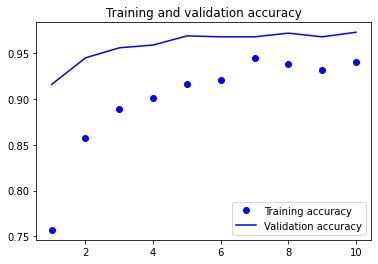

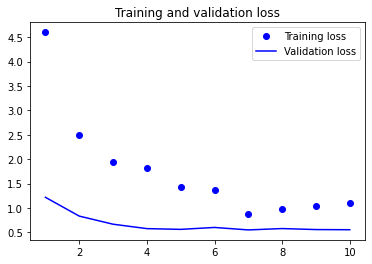

In [10]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Ejercicio:
---------

1. Revise los accuracy durante el entrenamiento para todas las mejoras que se han hecho a la BD de perros y gatos.
2. Pruebe con regularización y dropout ¿Qué obtiene?